In [12]:
import sys
sys.path.append('../')

,image_name,label,path,train,label_id,image_id
0,image25107.jpg,apparel,images/apparel/image25107.jpg,True,9,0
1,image26799.jpg,apparel,images/apparel/image26799.jpg,True,9,1
2,image23088.jpg,apparel,images/apparel/image23088.jpg,True,9,2
3,image0421.jpg,apparel,images/apparel/image0421.jpg,True,9,3


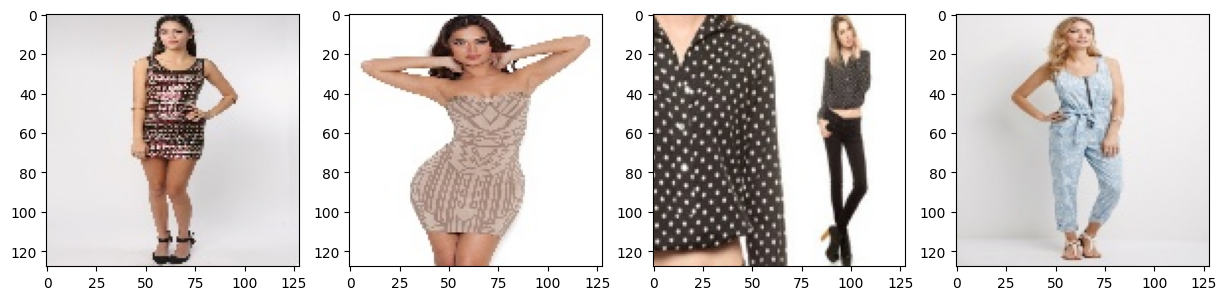

In [13]:
import cv2                      # Image Ops
import pandas as pd             # Other
import numpy as np              # Mat Opts
import matplotlib.pyplot as plt # Show Images

from utils.utils import load_images
from utils.features import load_features, save_features, extract_features
from utils.matching import minmin_retrival, match_all_images
from utils.scoring import calculate_metrics

from functools import partial


image_meta, images = load_images(True) # True - Train Images
display(image_meta.head(4))

_, ax = plt.subplots(1, 4, figsize = (15, 6))
ax[0].imshow(images[0]);
ax[1].imshow(images[1]);
ax[2].imshow(images[2]);
ax[3].imshow(images[3]);

# Características
Se plantea usar como características el histograma de diferencia de color para imágenes RGB. Se explica en la [siguiente publicación](https://www.sciencedirect.com/science/article/pii/S0031320312002713?via%3Dihub)
 

In [14]:
import torch
import torch.nn as nn
from torchvision import models, transforms

# Cargar el modelo preentrenado ResNet-18
modelo = models.resnet18(pretrained=True)
modelo.eval()  # Establecer el modelo en modo de evaluación
    
def cnn_descriptor(imagen_numpy, modelo):
    # Convertir el numpy array en un tensor de PyTorch
    imagen_numpy = imagen_numpy.transpose(2, 0, 1)
    imagen_tensor = torch.from_numpy(imagen_numpy).unsqueeze(0).float()

    # Definir la transformación para preprocesar la imagen
    preprocesamiento = transforms.Compose([
        transforms.ToPILImage(),  # Convierte el tensor a una imagen de PIL
        transforms.Resize(256),    # Redimensiona la imagen a 256x256
        transforms.CenterCrop(224),  # Recorta la imagen al centro 224x224
        transforms.ToTensor(),      # Convierte la imagen de PIL a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normaliza los valores de los píxeles
    ])
    # Aplicar la transformación a la imagen
    imagen_preprocesada = preprocesamiento(imagen_tensor[0])

    # Extraer características de la imagen preprocesada
    with torch.no_grad():
        caracteristicas = modelo(imagen_preprocesada.unsqueeze(0))
        
    descriptor = np.array(caracteristicas)

    return descriptor

cnn_descriptor_partial = partial(cnn_descriptor, modelo = modelo)

c:\Users\Borrar_despues\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Borrar_despues\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# Convertir las imágenes a escala de grises y aplicar SIFT en el subconjunto de imágenes
descriptors, index = extract_features(cnn_descriptor_partial, images, min_features=1, progress = False)
print("Tamaño de  descriptores:", descriptors.shape[1])
print("Número de  descriptores:", descriptors.shape[0])
print("Número Máximo de Descriptores Por Imágen :", pd.value_counts(index).max())
print("Número Medio  de Descriptores Por Imágen :", pd.value_counts(index).mean().round(0).astype(int))
print("Número Mínimo de Descriptores Por Imágen :", pd.value_counts(index).min())

# Obligatorio Siempre Guardar
save_features(descriptors, index, image_meta, "CNN")

Tamaño de  descriptores: 1000
Número de  descriptores: 550
Número Máximo de Descriptores Por Imágen : 1
Número Medio  de Descriptores Por Imágen : 1
Número Mínimo de Descriptores Por Imágen : 1


In [16]:
desc_meta, descriptors = load_features("../features/CNN.csv") # Siempre Cargar
display(desc_meta.head())
display(descriptors.dtype)

,image_id,label_id
0,0,9
1,1,9
2,2,9
3,3,9
4,4,9


dtype('float32')

,image_name,label,path,train,label_id,image_id
0,image6479.jpg,apparel,images/apparel/image6479.jpg,False,9,0
1,image2791.jpg,apparel,images/apparel/image2791.jpg,False,9,1
2,image9608.jpg,apparel,images/apparel/image9608.jpg,False,9,2
3,image26288.jpg,apparel,images/apparel/image26288.jpg,False,9,3


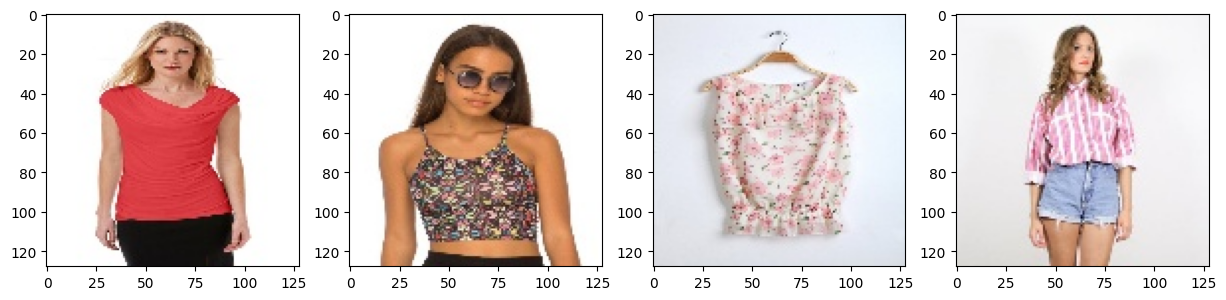

In [17]:
test_meta, test_images = load_images(False)

display(test_meta.head(4))

_, ax = plt.subplots(1, 4, figsize = (15, 6))
ax[0].imshow(test_images[0]);
ax[1].imshow(test_images[1]);
ax[2].imshow(test_images[2]);
ax[3].imshow(test_images[3]);


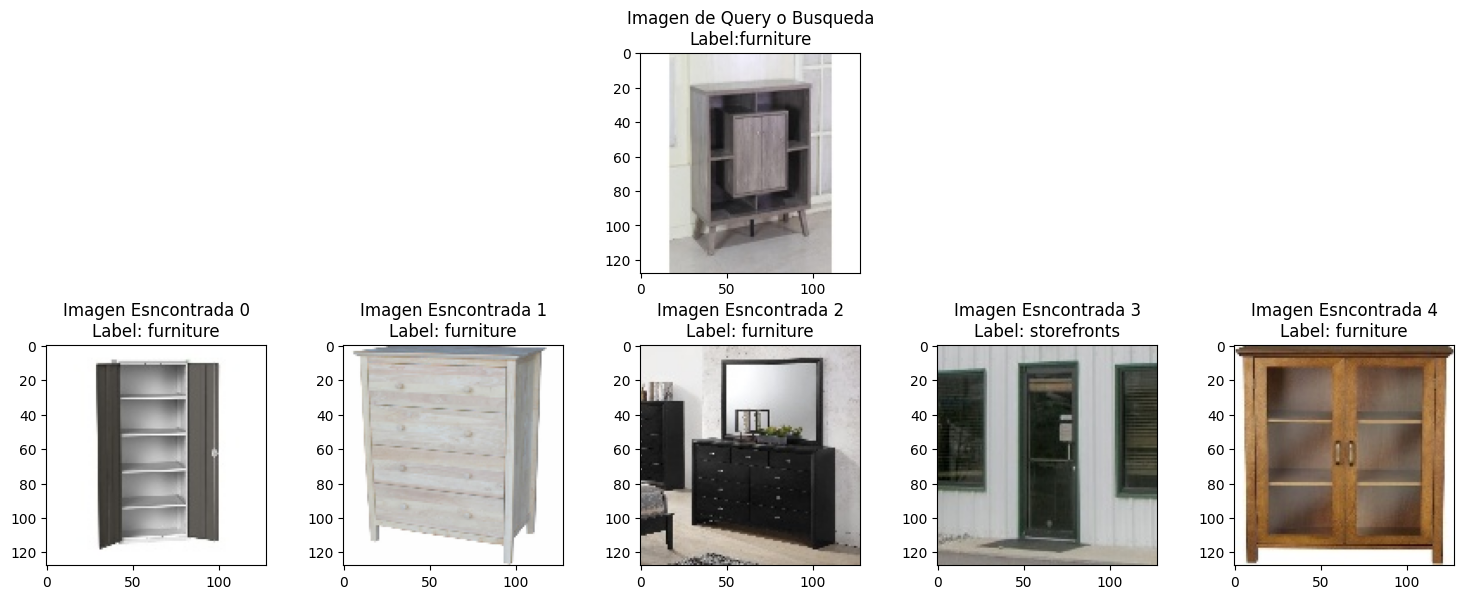

In [27]:
test_img = 40

img = test_images[test_img]
descs = cnn_descriptor_partial(img)
ret_idx = minmin_retrival(descs, descriptors, desc_meta, best_k=5, distance_function=cv2.NORM_L2)

fig, ax = plt.subplots(2, 5,  figsize = (15, 6))

ax[0][2].imshow(img)
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[test_img, 'label'])
for i, img_id in enumerate(ret_idx[:5], start = 0):
    ax[1][i].imshow(images[img_id])
    label = image_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Esncontrada {i}\nLabel: {label}");

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()


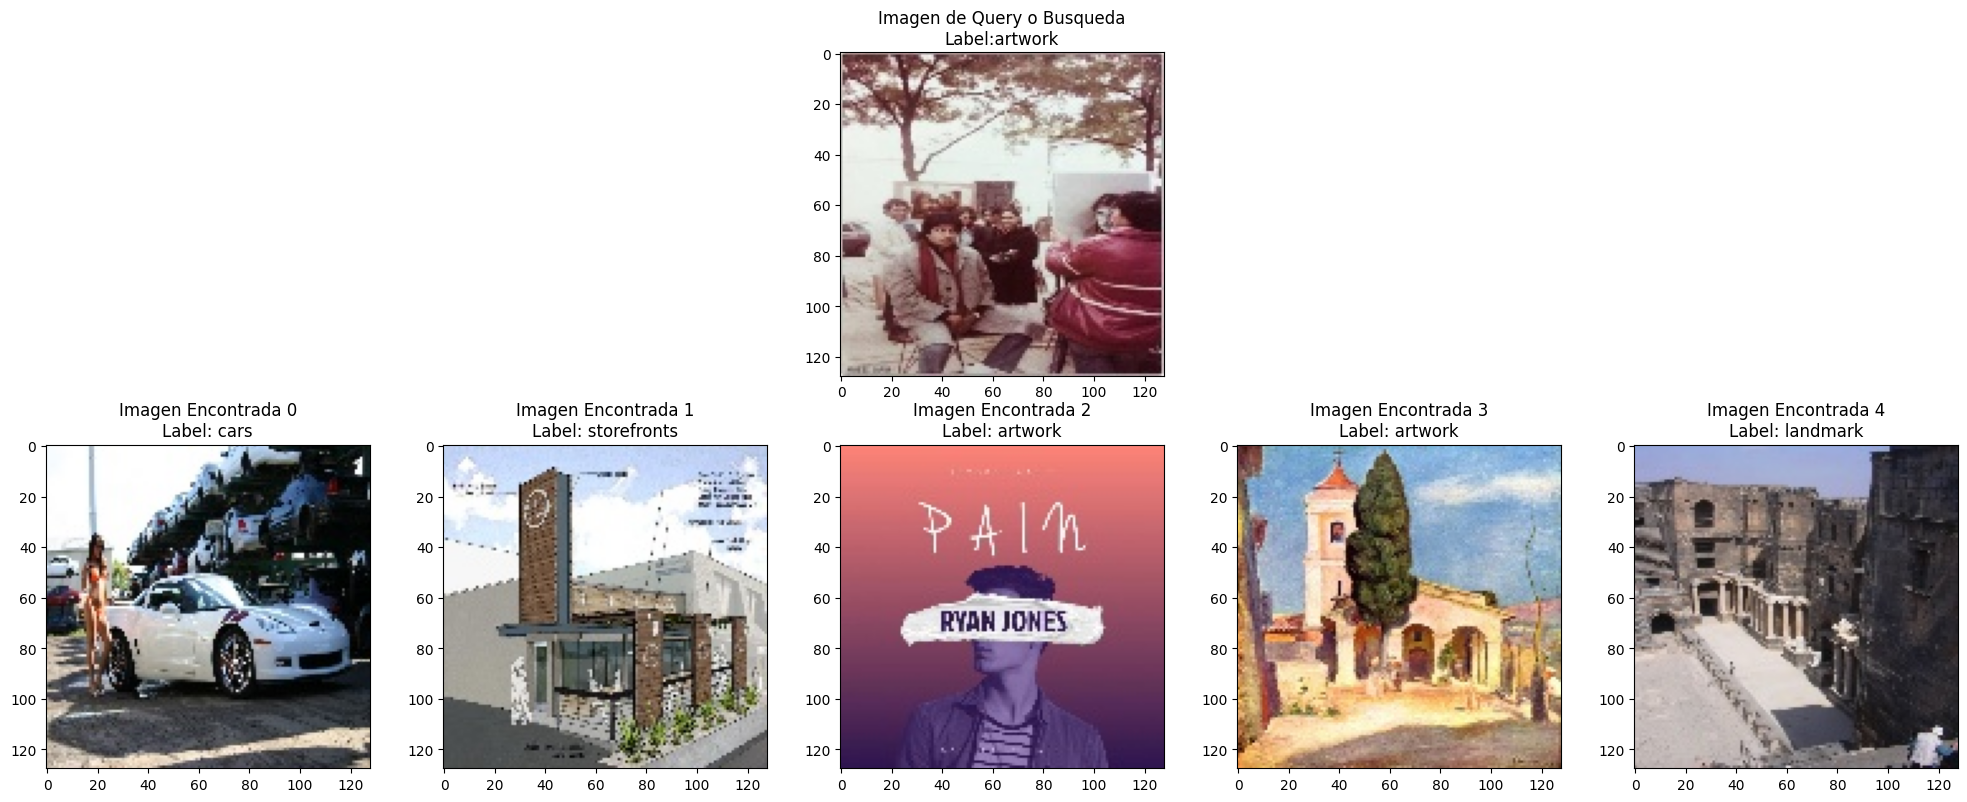

In [19]:
%reload_ext autoreload 
%autoreload 2
test_decs, test_desc_meta = extract_features(cnn_descriptor_partial, test_images, progress=False)

xr = match_all_images(test_decs, test_meta, descriptors, desc_meta, best_k=10, distance_function=cv2.NORM_L1)
fig, ax = plt.subplots(2, 5,  figsize = (20, 8))

test_img = 10
ax[0][2].imshow(test_images[test_img])
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[test_img, 'label'])
for i, img_id in enumerate(xr[test_img][:5], start = 0):
    ax[1][i].imshow(images[img_id])
    label = image_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Encontrada {i}\nLabel: {label}");

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()


In [20]:
calculate_metrics(xr, image_meta, test_meta, scores = (1, 5, 10))

,Precision@K,Recall@K,R-Precision@K
K,,,
1,0.554545,0.011091,0.554545
5,0.489091,0.048909,0.489091
10,0.456364,0.091273,0.456364


In [21]:
"""
from tqdm import tqdm
rprecision1 = []
rprecision5 = []
rprecision10 = []
rprecision25 = []
rprecision50 = []
bins = [32] #list(range(32, 257, 16))
for b in tqdm(bins):

    train_desc, train_index = extract_features(cnn_descriptor_partial, images)
    test_desc , test_index  = extract_features(cnn_descriptor_partial, test_images)

    results = match_all_images(test_desc, test_index, train_desc, train_index, best_k=50, distance_function=cv2.NORM_L2)
    rprecision = calculate_metrics(results, image_meta, test_meta, scores = (1, 5, 10, 25, 50))

    rprecision1.append(rprecision['R-Precision@1'])
    rprecision5.append(rprecision['R-Precision@5'])
    rprecision10.append(rprecision['R-Precision@10'])
    rprecision25.append(rprecision['R-Precision@25'])
    rprecision50.append(rprecision['R-Precision@50'])

plt.plot(bins, rprecision1 , 'r', label = "R-Precision@1")
plt.plot(bins, rprecision5 , 'b', label = "R-Precision@5")
plt.plot(bins, rprecision10, 'g', label = "R-Precision@10")
plt.plot(bins, rprecision25,      label = "R-Precision@25")
plt.plot(bins, rprecision50,      label = "R-Precision@50")
plt.legend(bbox_to_anchor = (1, 1))
plt.show()
"""

'\nfrom tqdm import tqdm\nrprecision1 = []\nrprecision5 = []\nrprecision10 = []\nrprecision25 = []\nrprecision50 = []\nbins = [32] #list(range(32, 257, 16))\nfor b in tqdm(bins):\n\n    train_desc, train_index = extract_features(cnn_descriptor_partial, images)\n    test_desc , test_index  = extract_features(cnn_descriptor_partial, test_images)\n\n    results = match_all_images(test_desc, test_index, train_desc, train_index, best_k=50, distance_function=cv2.NORM_L2)\n    rprecision = calculate_metrics(results, image_meta, test_meta, scores = (1, 5, 10, 25, 50))\n\n    rprecision1.append(rprecision[\'R-Precision@1\'])\n    rprecision5.append(rprecision[\'R-Precision@5\'])\n    rprecision10.append(rprecision[\'R-Precision@10\'])\n    rprecision25.append(rprecision[\'R-Precision@25\'])\n    rprecision50.append(rprecision[\'R-Precision@50\'])\n\nplt.plot(bins, rprecision1 , \'r\', label = "R-Precision@1")\nplt.plot(bins, rprecision5 , \'b\', label = "R-Precision@5")\nplt.plot(bins, rprecisi